In [1]:
# Increase notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
# Efficient math and data management
import numpy as np
import pandas as pd

# You may import useful modules and functions from the Python Standard Library.
import os
from functools import reduce  

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from scipy.sparse.linalg import lsqr
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

# Visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Inline figures. Can swap comments to use interactive figures. Use inline figures for assignment submission.
%matplotlib inline
# %matplotlib notebook

In [4]:
# Set seaborn visual style
sns.set()
sns.set_context('talk')
plt.rcParams["patch.force_edgecolor"] = False  # Turn off histogram borders

In [5]:
#Read in the data
data_dir = './nhanes'

data = {}
for filename in os.listdir(data_dir):
    file = os.path.abspath(os.path.join(data_dir, filename))
    name, ext = os.path.splitext(os.path.basename(file))
    if ext.lower() == '.xpt':
        data[name[:-2]] = pd.read_sas(file, encoding='UTF-8')

In [6]:
def join_files(a, b): 
    return a.merge(b, on='SEQN', how='outer')

intersect_data = reduce(join_files, [data[k] for k in data]) 
model_data = intersect_data[['SEQN','SLD012','ALQ130','DUQ230','PAQ610','BMXBMI','SMD650','OCQ180']]

DPQ = intersect_data[['SEQN','DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090']]

In [7]:
def depression_status(score): #Returns a label based on PHQ-9 measures
    if score < 5:
        return 'None'
    elif score >=5 and score < 10:
        return 'Mild'
    elif score >=10 and score < 15:
        return 'Moderate'
    elif score >=15 and score < 20:
        return 'Moderately Severe'
    else: 
        return 'Severe Depression'    

DPQ = DPQ.round() #fix a weird read_sas format
backup_SEQN = DPQ['SEQN'] 

DPQ = DPQ[(DPQ.loc[:,'DPQ010':'DPQ090'] < 4)] # Removes responses greater than 4, which also unfortunately messes up SEQN column
DPQ['SEQN'] = backup_SEQN # Fixes SEQN column
DPQ = DPQ.dropna() # Drops na values and rows who's responses weren't between 0-3

DPQ['D-Score'] = DPQ['DPQ010'] + DPQ['DPQ020'] + DPQ['DPQ030'] + DPQ['DPQ040'] + DPQ['DPQ050'] + DPQ['DPQ060'] + DPQ['DPQ070'] + DPQ['DPQ080'] + DPQ['DPQ090']

DPQ['Depression'] = DPQ['D-Score'].apply(lambda x: depression_status(x))

dscores = DPQ

DPQ = DPQ[['SEQN', 'Depression']]

In [8]:
print(DPQ.Depression.value_counts(normalize=True)) #I thought this statistic was neat

None                 0.744278
Mild                 0.165154
Moderate             0.057616
Moderately Severe    0.024467
Severe Depression    0.008485
Name: Depression, dtype: float64


In [9]:
model_data = join_files(model_data, DPQ)

#model_data['DUQ'] = model_data['DUQ230'].fillna(0) + model_data['DUQ280'].fillna(0) + model_data['DUQ320'].fillna(0) + model_data['DUQ360'].fillna(0)
#model_data = model_data.drop(['DUQ230', 'DUQ280', 'DUQ320', 'DUQ360'], axis = 1)
#There's a weird warning that happens if I try to add DUQ before DPQ

In [10]:
#data that needs refusals and don't know to be dropped ALQ130, DUQ230, PAQ610, SMD650, OCQ180

model_data['ALQ130'] = model_data['ALQ130'].fillna(0) # 0 drinks consumed, there's no range for 0 drinks
alqdel = model_data[(model_data['ALQ130'] == 777) | (model_data['ALQ130'] == 999)].index
model_data.drop(alqdel, inplace = True)

paqdel = model_data[(model_data['PAQ610'] == 77) | (model_data['PAQ610'] == 99)].index
model_data.drop(paqdel, inplace = True)

smddel = model_data[(model_data['SMD650'] == 777) | (model_data['SMD650'] == 999)].index
model_data.drop(smddel, inplace = True)

ocqdel = model_data[(model_data['OCQ180'] == 77777) | (model_data['OCQ180'] == 77777)].index
model_data.drop(ocqdel, inplace = True)

model_data['DUQ230'] = model_data['DUQ230'].fillna(0)
duqdel = model_data[(model_data['DUQ230'] == 777) | (model_data['DUQ230'] == 999)].index
model_data.drop(duqdel, inplace = True)


In [11]:
model_data = model_data.dropna()
model_data

SEQN  SLD012  ALQ130  DUQ230  PAQ610  BMXBMI  SMD650  OCQ180  \
5      93712.0     7.5     0.0     1.0     6.0    19.7     2.0    55.0   
26     93743.0     5.5     0.0     0.0     7.0    22.5    20.0    53.0   
36     93761.0     8.0     2.0     0.0     5.0    29.0    10.0    40.0   
174    93972.0     6.5     5.0     0.0     5.0    29.6    10.0    55.0   
185    93987.0     6.5     7.0     0.0     5.0    39.2     8.0    32.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
5491  102884.0     9.0     4.0     0.0     5.0    31.7     2.0    60.0   
5513  102918.0     9.0     6.0     0.0     5.0    22.4    10.0    40.0   
5516  102922.0     3.5     3.0     0.0     6.0    20.8    11.0    55.0   
5521  102934.0     7.5     3.0     0.0     5.0    26.3    12.0    40.0   
5528  102949.0     6.5     0.0     5.0     3.0    23.7    20.0    80.0   

     Depression  
5          None  
26         Mild  
36         None  
174        None  
185        None  
...         ...  
5491       None  
5513       None  
5516       None  
5521       None  
5528       None  

[210 rows x 9 columns]

In [12]:
train_features = model_data.iloc[:, 1:8]
train_labels = model_data.iloc[:, -1]

np.random.seed(0)

test_frac = 0.3

X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=test_frac, random_state=0)

In [13]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth = None, min_samples_split=2).fit(X_train, y_train)
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
accuracy = model.score(X_test, y_test)

In [15]:
#A bunch of testing happens here and below
accuracy

0.6825396825396826

In [16]:
y_test.value_counts(normalize=True)

None                 0.714286
Mild                 0.142857
Moderate             0.079365
Moderately Severe    0.063492
Name: Depression, dtype: float64

In [17]:
importances = model.feature_importances_
sorted_idx = model.feature_importances_.argsort()

features = model_data.iloc[:, 1:8].columns[sorted_idx]
importances = importances[sorted_idx]


print('Feature Importance Rankings')
for f, i in zip(features, importances):
    print(f, ': Importance', i.round(3))

Feature Importance Rankings
DUQ230 : Importance 0.082
PAQ610 : Importance 0.102
ALQ130 : Importance 0.131
SMD650 : Importance 0.152
OCQ180 : Importance 0.157
SLD012 : Importance 0.161
BMXBMI : Importance 0.214


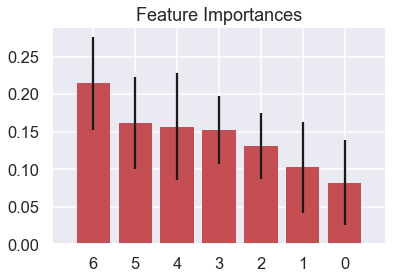

In [18]:
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

0.6825396825396826


Text(0.5, 1.0, 'Forest 1: All Feature Importance')

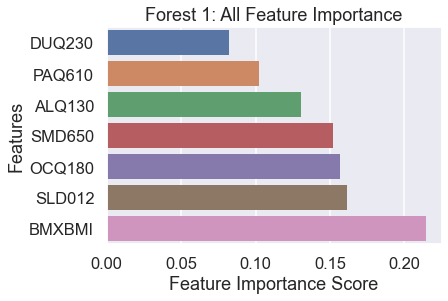

In [19]:
# Add stds?


print(accuracy)

sns.barplot(x=importances, y=features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Forest 1: All Feature Importance')

In [20]:
#from sklearn import tree

#fn=features
#cn=y_test
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
#tree.plot_tree(model.estimators_[5],
#               feature_names = fn, 
#               class_names=cn,
#               filled = True);
#fig.savefig('rf_individualtree.png')

0.6507936507936508


Text(0.5, 1.0, 'Forest 2: Top 4 Feature Importance')

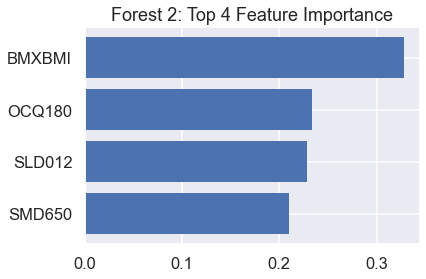

In [21]:
#Random Forest 2 where it's just the featues that had an importance of .15 and higher

data2 = model_data[['SLD012', 'OCQ180', 'BMXBMI', 'SMD650','Depression']]
train_features = data2.iloc[:, :-1]
train_labels = data2.iloc[:, -1]

np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth = None, min_samples_split=2).fit(X_train, y_train)
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
accuracy = model.score(X_test, y_test)

print(accuracy)

importances = model.feature_importances_
sorted_idx = model.feature_importances_.argsort()

features = data2.iloc[:, :-1].columns[sorted_idx]
importances = importances[sorted_idx]

plt.barh(features, importances)
plt.title('Forest 2: Top 4 Feature Importance')

Text(0.5, 1.0, 'Forest 2: Top 4 Feature Importance')

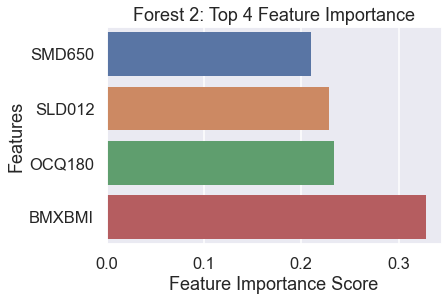

In [22]:
sns.barplot(x=importances, y=features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Forest 2: Top 4 Feature Importance')

In [23]:
#I changed this to also make Forest 3
data2 = model_data[['SLD012', 'OCQ180', 'BMXBMI', 'SMD650', 'PAQ610', 'ALQ130','Depression']]
train_features = data2.iloc[:, :-1]
train_labels = data2.iloc[:, -1]

np.random.seed(0)

X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.3, random_state=0)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth = None, min_samples_split=2).fit(X_train, y_train)
y_hat = model.predict(X_test)
scores = model.predict_proba(X_test)[:, 1]
accuracy = model.score(X_test, y_test)

print(accuracy)

importances = model.feature_importances_
sorted_idx = model.feature_importances_.argsort()

features = data2.iloc[:, :-1].columns[sorted_idx]
importances = importances[sorted_idx]


0.6825396825396826


Text(0.5, 1.0, 'Forest 3: DUQ Removed')

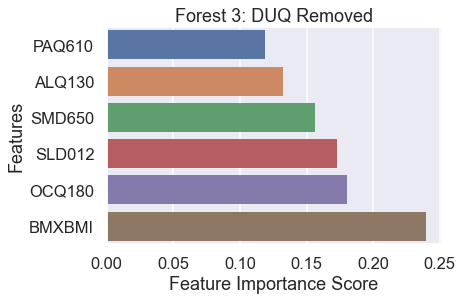

In [24]:
sns.barplot(x=importances, y=features)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Forest 3: DUQ Removed')

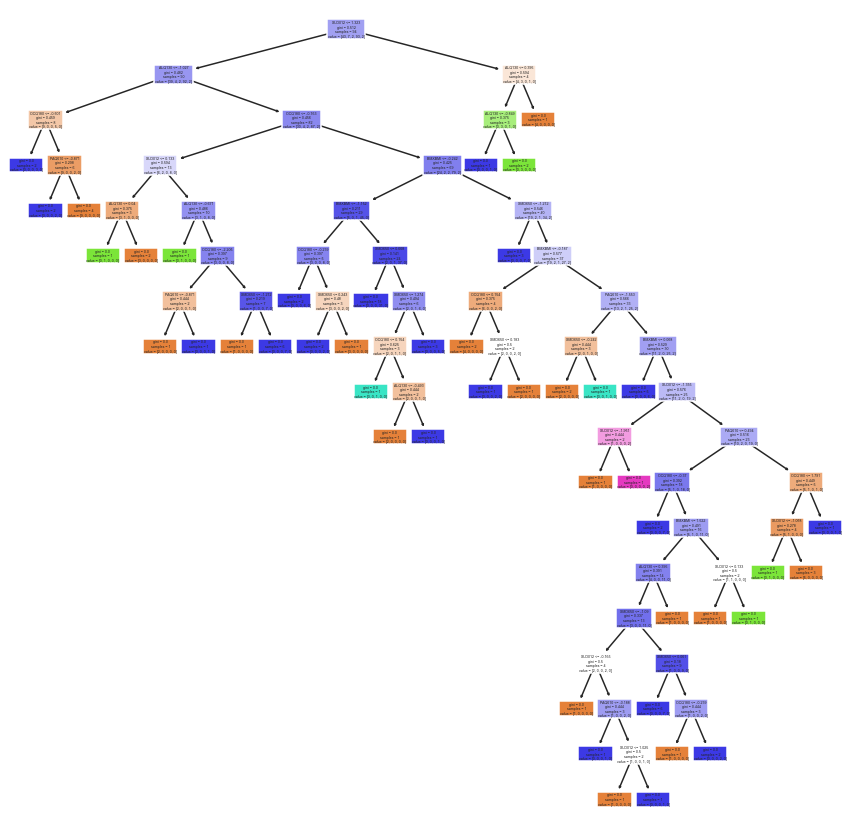

In [25]:
from sklearn import tree
plt.figure(figsize=(15,15))
_ = tree.plot_tree(model.estimators_[0], feature_names=list(data2.columns), filled=True)

In [26]:
model_data

SEQN  SLD012  ALQ130  DUQ230  PAQ610  BMXBMI  SMD650  OCQ180  \
5      93712.0     7.5     0.0     1.0     6.0    19.7     2.0    55.0   
26     93743.0     5.5     0.0     0.0     7.0    22.5    20.0    53.0   
36     93761.0     8.0     2.0     0.0     5.0    29.0    10.0    40.0   
174    93972.0     6.5     5.0     0.0     5.0    29.6    10.0    55.0   
185    93987.0     6.5     7.0     0.0     5.0    39.2     8.0    32.0   
...        ...     ...     ...     ...     ...     ...     ...     ...   
5491  102884.0     9.0     4.0     0.0     5.0    31.7     2.0    60.0   
5513  102918.0     9.0     6.0     0.0     5.0    22.4    10.0    40.0   
5516  102922.0     3.5     3.0     0.0     6.0    20.8    11.0    55.0   
5521  102934.0     7.5     3.0     0.0     5.0    26.3    12.0    40.0   
5528  102949.0     6.5     0.0     5.0     3.0    23.7    20.0    80.0   

     Depression  
5          None  
26         Mild  
36         None  
174        None  
185        None  
...         ...  
5491       None  
5513       None  
5516       None  
5521       None  
5528       None  

[210 rows x 9 columns]

In [27]:
#t test
from scipy import stats

np.random.seed(0)

dscores = dscores[['SEQN', 'D-Score']]
ttest_data = join_files(model_data, dscores).dropna()
goodsleep = ttest_data[ttest_data['SLD012'] >=7]['D-Score'].sample(n=50)
badsleep = ttest_data[ttest_data['SLD012'] < 7]['D-Score'].sample(n=50)

In [28]:
ttest = stats.ttest_ind(goodsleep, badsleep, equal_var = False)
print('P-value:', ttest.pvalue.round(3))
print('t-statistic:', ttest.statistic.round(3))

P-value: 0.013
t-statistic: -2.53


In [29]:
len(ttest_data.dropna())

210